# Exploratory Data Analysis

In [296]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [222]:

raw_data = pd.read_csv("mushrooms.csv")
data = raw_data

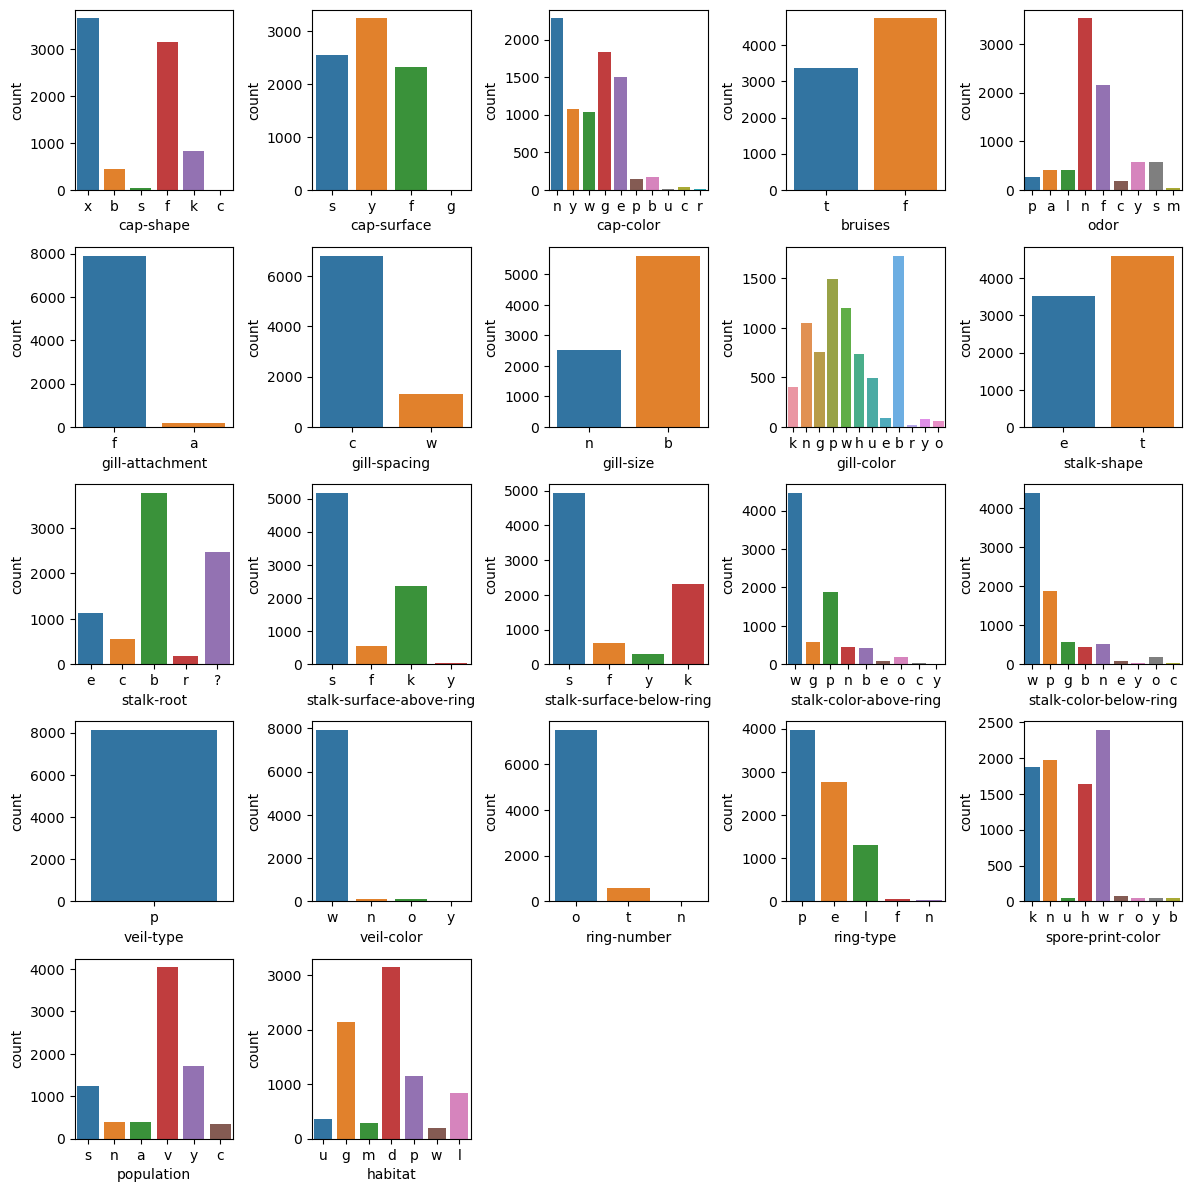

In [223]:
counts_fig = plt.figure(figsize=(12,12))

for i, col in enumerate(data.columns[1:]):
    ax = counts_fig.add_subplot(5,5,i+1)
    sns.countplot(ax=ax, data=data, x=col)

counts_fig.tight_layout(pad=1.0)

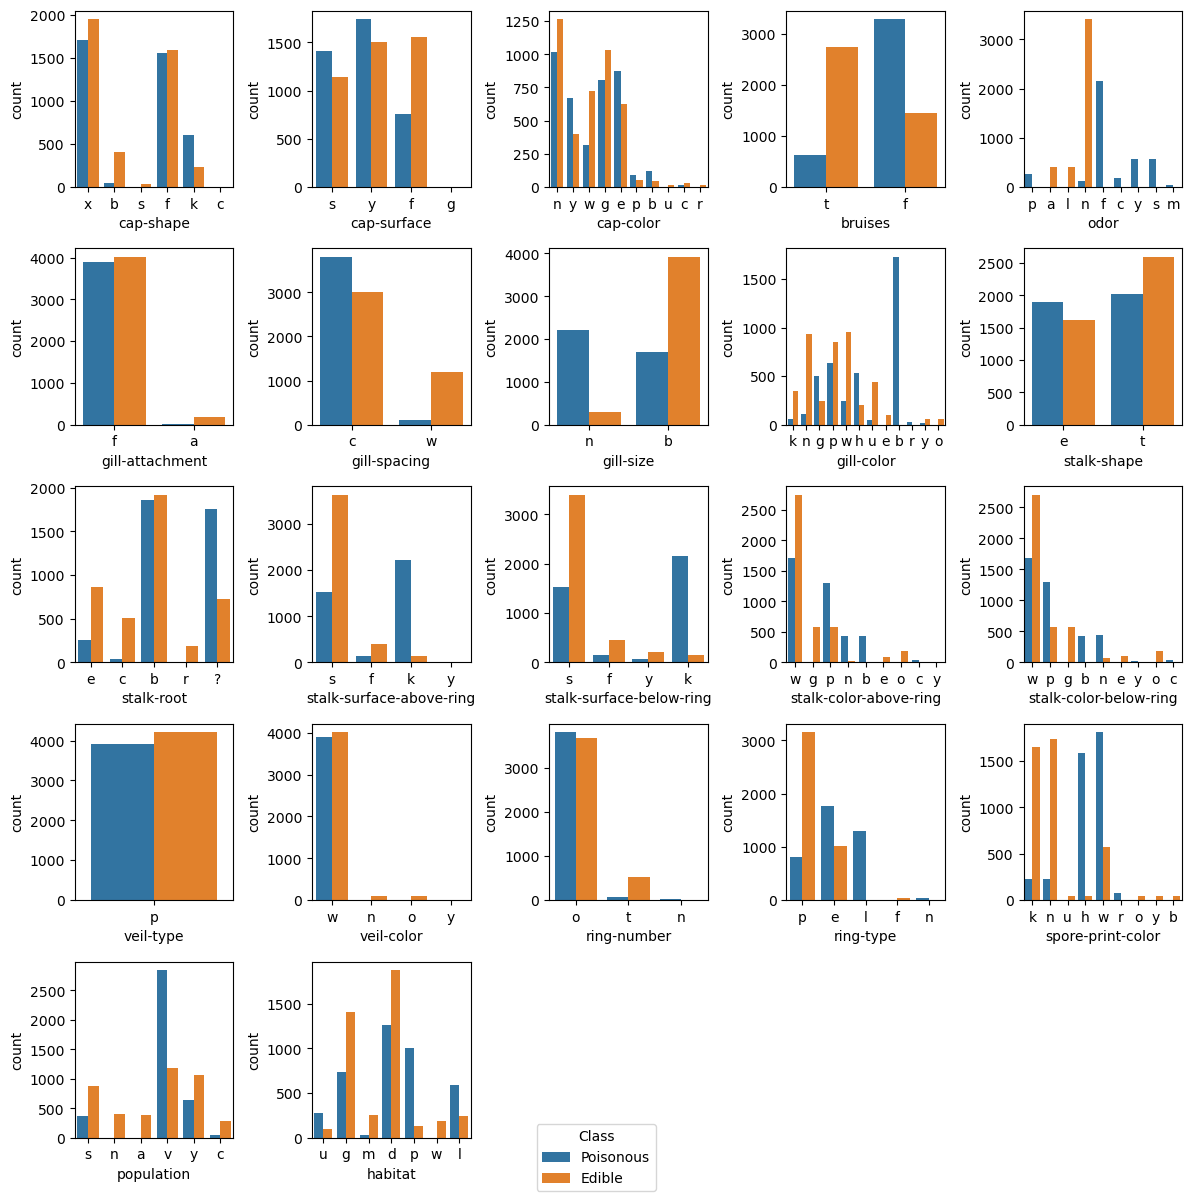

In [224]:

class_counts_fig = plt.figure(figsize=(12,12))

for i, col in enumerate(data.columns[1:]):
    ax = class_counts_fig.add_subplot(5,5,i+1)
    sns.countplot(ax=ax, data=data, x=col, hue="class")
    ax.get_legend().remove()

handles, labels = class_counts_fig.axes[0].get_legend_handles_labels()
class_counts_fig.legend(handles, ["Poisonous", "Edible"], title="Class", loc='lower center')
class_counts_fig.tight_layout(pad=1.0)

In [225]:
feature_drop_threshold = 0.8
condensation_threshold = 0.1
columns_to_drop = ['stalk-root']
for column in data:
    counts = data[column].value_counts(normalize=True)

    # Mark to remove column if too much data is in one level
    if(counts[0] > feature_drop_threshold):
        columns_to_drop.append(column)

    # Condense levels below threshold
    mask = counts.lt(condensation_threshold)
    condensed_levels = counts[mask].index
    data[column] = np.where(data[column].isin(condensed_levels), "other", data[column])

print(columns_to_drop)

data = data.drop(columns=columns_to_drop)

focus_columns = [
    'class',
    'cap-shape',
    'cap-color',
    'bruises',
    'odor',
    'gill-size',
    'gill-color',
    'stalk-shape',
    'stalk-color-above-ring',
    'stalk-color-below-ring',
    'population',
    'habitat'
]
data = data[focus_columns]

['stalk-root', 'gill-attachment', 'gill-spacing', 'veil-type', 'veil-color', 'ring-number']


# Baseline Models

## Logisitic Regression

In [226]:

rng = np.random.RandomState(seed = 7406)
y = pd.DataFrame({"class":data["class"]})
X = data.drop(columns="class")
oh_enc = OneHotEncoder(sparse_output=False).set_output(transform = "pandas").fit(X)
ord_enc = OrdinalEncoder().fit(y)


In [288]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

X_train_encoded = oh_enc.transform(X_train)
X_test_encoded = oh_enc.transform(X_test)
y_train_encoded = ord_enc.transform(y_train).ravel()

feature_groups = []
for feature in oh_enc.feature_names_in_:
    this_group = [colname for colname in oh_enc.get_feature_names_out() if feature in colname]
    feature_groups.append(this_group)

In [289]:

sfs_log_reg = SFS(LogisticRegression(), k_features="best", forward=True, floating=True,
    feature_groups=feature_groups, n_jobs=cpu_count())
sfs_log_reg.fit(X_train_encoded, y_train_encoded)

set([feature.split('_')[0] for feature in sfs_log_reg.k_feature_names_])

{'gill-color',
 'gill-size',
 'habitat',
 'odor',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'stalk-shape'}

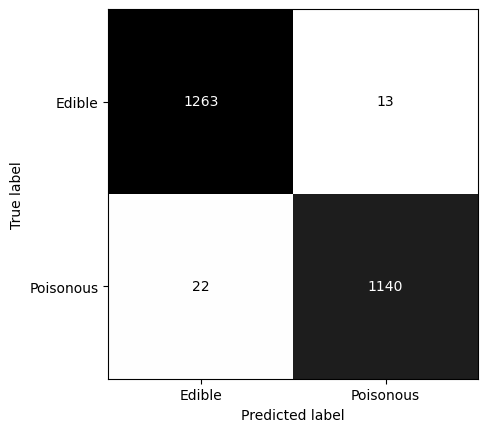

In [290]:
X_train_logit_sfs = sfs_log_reg.transform(X_train_encoded)
X_test_logit_sfs = sfs_log_reg.transform(X_test_encoded)
y_test_encoded = ord_enc.transform(pd.DataFrame(y_test, columns=["class"]))

logit_model = LogisticRegression().fit(X_train_logit_sfs, y_train_encoded)

ConfusionMatrixDisplay.from_estimator(logit_model, X_test_logit_sfs, y_test_encoded,
    display_labels=["Edible", "Poisonous"], cmap="Greys", colorbar=False)

## KNN

{'n_neighbors': 3}


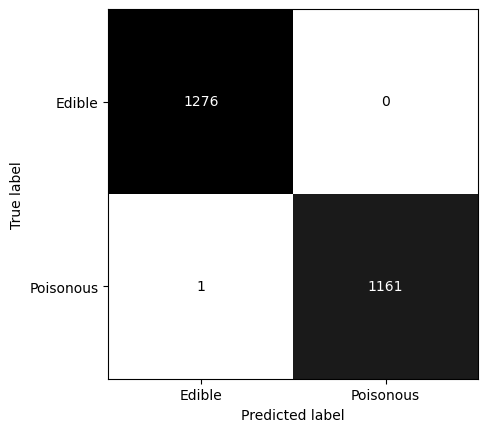

In [291]:
param_grid = {
    "n_neighbors": np.arange(start=3, stop=25, step=2),
}

knn_model = GridSearchCV(estimator=KNeighborsClassifier(),
                      param_grid=param_grid,
                      scoring='accuracy', cv = 5,
                      n_jobs=cpu_count(), refit = True)
knn_model.fit(X_train_encoded, y_train_encoded)
print(knn_model.best_params_)

ConfusionMatrixDisplay.from_estimator(knn_model, X_test_encoded, y_test_encoded,
    display_labels=["Edible", "Poisonous"], cmap="Greys", colorbar=False)

## Decision Tree

In [309]:
tree_sfs = SFS(DecisionTreeClassifier(random_state=rng), k_features="best", forward=True, floating=True,
    feature_groups=feature_groups, n_jobs=cpu_count())
tree_sfs.fit(X_train_encoded, y_train_encoded)

set([feature.split('_')[0] for feature in sfs_log_reg.k_feature_names_])

{'gill-color',
 'gill-size',
 'habitat',
 'odor',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'stalk-shape'}

{'ccp_alpha': 7.117810293438647e-05}


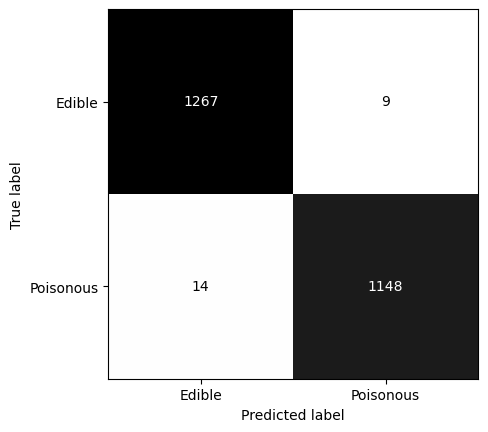

In [322]:
X_train_tree_sfs = sfs_log_reg.transform(X_train_encoded)
X_test_tree_sfs = sfs_log_reg.transform(X_test_encoded)
tree_model = DecisionTreeClassifier(random_state=rng, min_samples_leaf=10).fit(X_train_tree_sfs, y_train_encoded)

path = tree_model.cost_complexity_pruning_path(X_train_tree_sfs, y_train_encoded)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
param_grid = {
    "ccp_alpha": ccp_alphas
}

tree_model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=rng),
                      param_grid=param_grid,
                      scoring='accuracy', cv = 5,
                      n_jobs=cpu_count(), refit = True)
tree_model.fit(X_train_tree_sfs, y_train_encoded)
print(tree_model.best_params_)

# plt.figure(figsize=(15,15))
# plot_tree(tree_model, feature_names=X_train_encoded.columns,class_names=["Edible","Poisonous"], filled=True)
# plt.show()

ConfusionMatrixDisplay.from_estimator(tree_model, X_test_tree_sfs, y_test_encoded,
    display_labels=["Edible", "Poisonous"], cmap="Greys", colorbar=False)